# Processando e explorando dados em um banco relacional

## Importando pacotes

In [1]:
import dataframe_image as dfi
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from bokeh.plotting import output_notebook, show, figure
from bokeh.models import ColumnDataSource, HoverTool
from nycflights13 import airports, flights, planes, airlines, weather

### Atrasos

In [2]:
def atrasos (df):
    """
    Calcula o atraso médio, desvio-padrão, assimetria e curtose.

    Retorna um dataframe com os valores de cada cálculo.
    """


    # cria uma cópia do DF flights
    df_flights = df.copy(deep=True)

    # formatando datas
    df_flights['data'] = pd.to_datetime(df_flights[['day','month']].assign(Year=2013)).astype('string')

    # somando os atrasos
    df_flights['sum'] = df_flights[['dep_delay','arr_delay']].sum(axis=1,skipna=True)# skipna irá ignorar todos os valores null/nan

    # cria um DF para cada cálculo
    func = {'media':'mean','desvio':'std','assimetria':'skew'}
    dfs = {}
    for key in func:
        df = df_flights.groupby(['month','day','data']).agg({'sum':func[key]}).reset_index().rename(columns={"sum":key})
        dfs.update({key:df})

    # concatena os DFs
    df_atraso = pd.concat([dfs['media'],dfs['desvio']['desvio'],dfs['assimetria']['assimetria']],axis=1)

    return df_atraso

In [3]:
df_atraso = atrasos(flights)
df_atraso

,month,day,data,media,desvio,assimetria
0,1,1,2013-01-01,23.979810,92.828987,9.330473
1,1,2,2013-01-02,26.232238,76.435534,4.098157
2,1,3,2013-01-03,16.513129,64.018518,3.628782
3,1,4,2013-01-04,6.974863,56.424330,3.568580
4,1,5,2013-01-05,4.188889,51.812762,5.835333
...,...,...,...,...,...,...
360,12,27,2013-12-27,10.777778,58.501226,2.825252
361,12,28,2013-12-28,4.716216,53.085805,4.151023
362,12,29,2013-12-29,40.173423,94.004181,2.762140
363,12,30,2013-12-30,20.445248,65.934058,3.486107


Infelizmente pelo método que utilizei não foi possível encontrar os valores de curtose para cada dia, conforme a célula abaixo.
Isso acontece devido a um problema na função "groupby", com [issue](https://github.com/pandas-dev/pandas/issues/40139) aberta ainda não solucionada. A estrutura seria da seguinte forma: ```  curtose = df_flights.groupby(['month','day','data']).agg({'sum':'kurt'}).reset_index().rename(columns={"sum":'curtose'})```

#### Plotagem

Para criar o gráfico a seguir, estou usando a biblioteca Bokeh, que permite fazer gráficos interativos baseado em JavaScript.

In [4]:
def plot_bokeh_atrasos (df):
    """
    Cria uma série histórica de média e desvio-padrão.
    """

    
    # construindo a base de dados
    datas = np.array(df_atraso['data'], dtype=np.datetime64)
    source = ColumnDataSource(data=dict(datas=datas,media=df_atraso['media'],desvio=df_atraso['desvio']))

    # base do gráfico
    plot_atraso1 = figure(
    title="Média e desvio-padrão dos atrasos de vôos da cidade de Nova Iorque em 2013 - linhas",
    x_axis_type="datetime",
    height=600,
    width=1200,
    )

    # adiciona as linhas
    l1 = plot_atraso1.line("datas","media",source=source,legend_label="Média",color="red",line_width=2)
    l2 = plot_atraso1.line("datas","desvio",source=source,legend_label="Desvio-padrão",color="blue",line_width=2)

    # tooltips
    tt1="media: @media"
    tt2="desvio: @desvio"

    # adiciona legendas a partir do mouse
    h1 = HoverTool(renderers=[l1],tooltips=tt1,mode="mouse")
    h2 = HoverTool(renderers=[l2],tooltips=tt2,mode="mouse")
    plot_atraso1.add_tools(h1,h2)

    # resultado
    output_notebook()
    return show(plot_atraso1)

In [5]:
plot_bokeh_atrasos(df_atraso)

Loading BokehJS ...

É possível exportar o gráfico em HTML ou PNG. Para o caso de imagens, é necessário ter o pacote Selenium para que ele extraia a imagem, quando usado em um navegador. Para saídas em HTML, todos os dados, assim como as interações do gráfico, são armazenadas no próprio arquivo. Também é possível possível criar uma aplicação web a partir do "Bokeh server".

O gráfico abaixo foi construído com a biblioteca Matplotlib

In [6]:
def plot_matplot_atrasos(df):
    """
    Cria uma série histórica relativa ao mês de média e desvio-padrão

    Retorna um PNG.
    """


    # construindo a base de dados
    def dados_mes(mes,df):
        """
        Retorna um DF filtrado pelo mês.
        """

        
        df_mes = df.loc[df['month'] == mes]
        return df_mes

    df_jan = dados_mes(1,df_atraso) # pode criar uma função pra retornar os 12 dfs referentes a cada mês
    y_media = df_jan['media'].tolist() # eixo y
    y_desvio = df_jan['desvio'].tolist() # eixo y 


    # criando a base do gráfico
    plot_atraso2, ax = plt.subplots(figsize=(12,8))
    x = np.arange(1,32)
    x_width = 0.35

    # adiciona as barras
    b1 = ax.bar(x - x_width/2, y_media, x_width, label="Média")
    b2 = ax.bar(x + x_width/2, y_desvio, x_width, label="Desvio-padrão")

    # configurando legendas
    ax.set_title('Média e desvio-padrão dos atrasos de vôos da cidade de Nova Iorque em JAN/2013 - barras')
    ax.set_xticks(x)
    ax.legend()

    # resultado
    plot_atraso2.show()

    return plot_atraso2.savefig("res_media-desvio_nycflight.png")

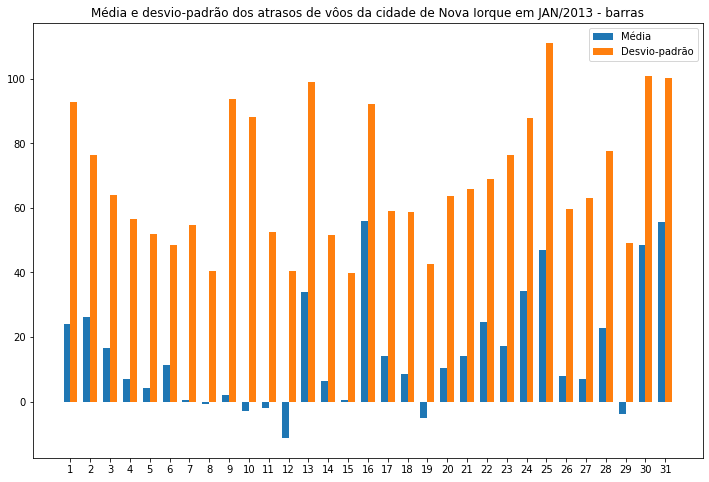

In [7]:
plot_matplot_atrasos(df_atraso)

### Vôos às segundas feitos por avisões fabricados em ano bissexto

In [8]:
def voos_segunda (df1,df2):
    """
    Retorna um dataframe de vôos realizados em segundas-feiras por aviões fabricados em ano bissexto.
    """


    # criando cópias dos DFs
    df_flights = df1.copy(deep=True)
    df_planes = df2.copy(deep=True)

    # formatando datas
    df_flights['data'] = pd.to_datetime(df_flights[['day','month']].assign(Year=2013))

    # adicionando coluna de dia da semana
    df_flights['semana'] = df_flights['data'].dt.day_name()

    # filtrando o DF para retornar vôos realizados em uma segunda
    df_seg = df_flights.loc[df_flights['semana'] == "Monday"]

    # filtrando o DF para retornar aviões fabricados em anos bissextos
    df_planes['leap_y'] = pd.to_datetime(df_planes['year'],format="%Y").dt.is_leap_year
    df_leap_y = df_planes.loc[df_planes['leap_y'] == True]

    # cruzando os DFs
    df_leap_y_seg = df_leap_y[df_leap_y['tailnum'].isin(df_seg['tailnum'])]

    return df_leap_y_seg

In [9]:
# quantitativo de vôos
quant_voos = len(voos_segunda(flights,planes))
quant_voos

832

In [10]:
df_voos_leap = voos_segunda(flights,planes)
df_voos_leap

,tailnum,year,type,manufacturer,model,engines,seats,speed,engine,leap_y
0,N10156,2004.0,Fixed wing multi engine,EMBRAER,EMB-145XR,2,55,NaN,Turbo-fan,True
20,N11155,2004.0,Fixed wing multi engine,EMBRAER,EMB-145XR,2,55,NaN,Turbo-fan,True
21,N11164,2004.0,Fixed wing multi engine,EMBRAER,EMB-145XR,2,55,NaN,Turbo-fan,True
22,N11165,2004.0,Fixed wing multi engine,EMBRAER,EMB-145XR,2,55,NaN,Turbo-fan,True
23,N11176,2004.0,Fixed wing multi engine,EMBRAER,EMB-145XR,2,55,NaN,Turbo-fan,True
...,...,...,...,...,...,...,...,...,...,...
3250,N965UW,2008.0,Fixed wing multi engine,EMBRAER,ERJ 190-100 IGW,2,20,NaN,Turbo-fan,True
3257,N967UW,2008.0,Fixed wing multi engine,EMBRAER,ERJ 190-100 IGW,2,20,NaN,Turbo-fan,True
3318,N997DL,1992.0,Fixed wing multi engine,MCDONNELL DOUGLAS AIRCRAFT CO,MD-88,2,142,NaN,Turbo-fan,True
3320,N998DL,1992.0,Fixed wing multi engine,MCDONNELL DOUGLAS CORPORATION,MD-88,2,142,NaN,Turbo-jet,True


#### Plotando

In [11]:
def plot_matplot_voos (df):
    """
    Cria um gráfico de barras do quantitativo de vôos feitos na cidade de Nova Iorque
    em segundas-feiras, com aeronaves fabricadas em ano bissexto, por ano.

    Retorna um PNG. 
    """


    # construindo a base de dados
    voos_leap = df['year'].astype(np.int64).value_counts(sort=False).to_dict()

    # criando a base do gráfico
    plot_voos_leap, ax2 = plt.subplots(figsize=(12,8))

    # adiciona as barras
    b3 = ax2.bar(range(len(voos_leap.keys())), list(voos_leap.values()), 0.35, align="center",tick_label=list(voos_leap.keys()))

    # configurando título
    ax2.set_title('Quantitativo de vôos feitos na cidade de Nova Iorque em segundas-feiras com aeronaves fabricadas em ano bissexto')

    # resultado
    plot_voos_leap.show()

    return plot_voos_leap.savefig("res_voos-leap_nycflight.png")

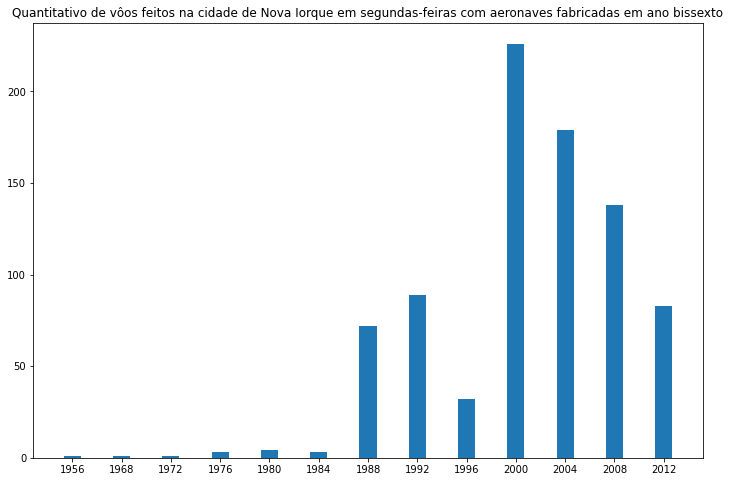

In [12]:
plot_matplot_voos(voos_segunda(flights,planes))

### Relação Vôos x Empresa aérea por aeroporto

In [13]:
def voos_totais (df):
    """
    Retorna um dataframe com a soma dos vôos de origem e destino
    """


    # gerando cópias de parte dos DFs com aeroportos e empresas
    df_voos_origin = df[['carrier','origin']].copy(deep=True).rename(columns={'origin':'faa'}) # troca no nome da coluna origin/dest para o mesmo nome que df_airporst
    df_voos_dest = df[['carrier','dest']].copy(deep=True).rename(columns={'dest':'faa'})

    # concatenação de DFs em função do aeroporto
    df_voos_airlines = pd.concat([df_voos_origin,df_voos_dest])

    return df_voos_airlines


def voos_aerop_empresa (df,index,coluna):
    """
    Retorna um dataframe com os quantitativos dos vôos de cada empresa por aeroporto
    """

    
    df_voos = pd.crosstab(index=df[index],columns=df[coluna])

    return df_voos

In [14]:
lon = voos_aerop_empresa(voos_totais(flights),'faa','carrier')
wide = voos_aerop_empresa(voos_totais(flights),'carrier','faa')

In [15]:
lon

carrier,9E,AA,AS,B6,DL,EV,F9,FL,HA,MQ,OO,UA,US,VX,WN,YV
faa,,,,,,,,,,,,,,,,
ABQ,0,0,0,254,0,0,0,0,0,0,0,0,0,0,0,0
ACK,0,0,0,265,0,0,0,0,0,0,0,0,0,0,0,0
ALB,0,0,0,0,0,439,0,0,0,0,0,0,0,0,0,0
ANC,0,0,0,0,0,0,0,0,0,0,0,8,0,0,0,0
ATL,59,0,0,0,10571,1764,0,2337,0,2322,0,103,0,0,59,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TPA,3,311,0,2800,2129,1,0,0,0,254,0,1968,0,0,0,0
TUL,0,0,0,0,0,315,0,0,0,0,0,0,0,0,0,0
TVC,0,0,0,0,0,68,0,0,0,33,0,0,0,0,0,0


In [16]:
wide

faa,ABQ,ACK,ALB,ANC,ATL,AUS,AVL,BDL,BGR,BHM,...,SNA,SRQ,STL,STT,SYR,TPA,TUL,TVC,TYS,XNA
carrier,,,,,,,,,,,,,,,,,,,,,
9E,0,0,0,0,59,2,10,0,1,0,...,0,78,0,0,170,3,0,0,308,0
AA,0,0,0,0,0,365,0,0,0,0,...,0,0,902,303,0,311,0,0,0,0
AS,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
B6,254,265,0,0,0,747,0,0,0,0,...,0,839,0,0,1266,2800,0,0,0,0
DL,0,0,0,0,10571,357,0,0,0,0,...,0,265,1,30,0,2129,0,0,0,0
EV,0,0,439,0,1764,0,265,435,374,297,...,0,29,1826,0,325,1,315,68,323,292
F9,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
FL,0,0,0,0,2337,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
HA,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


### Percentual de vôos que decolaram em condições abaixo da média anual no mês de dezembro

In [17]:
def percentual_visib_mes (df):
    """
    Retorna um dataframe com o percentual de vôos que decolaram em
    condições de visibilidade abaixo da média anual de cada aeroporto por mês.
    """

    
    # média anual de visibilidade
    media_visib = df['visib'].mean()

    
    dic_percent_mes = {}

    for mes in range(1,13):
        # DF filtrado apenas para o mês
        df_visib_mes = df.loc[df['month'] == mes]

        # DF com os vôos abaixo da média anual 
        df_abaixo_media = df_visib_mes.loc[df_visib_mes['visib'] < media_visib]

        percentual = (len(df_abaixo_media)/len(df_visib_mes))*100

        dic_percent_mes.update({mes:percentual})

    df_percent_mes = pd.Series(dic_percent_mes)
    
    return df_percent_mes


In [18]:
percent_mes = percentual_visib_mes(weather)
percent_mes[12]

29.384328358208954

## Exportando dataframes

In [24]:
# resposta topico 1
df_atraso.to_excel("res_df_atraso.xlsx")
# resposta topico 2
df_voos_leap.to_excel("res_df_voos-leap.xlsx")
# resposta topico 3
lon.to_excel("res_df_lon.xlsx")
# resposta topico 4
wide.to_excel("res_df_wide.xlsx")
# resposta topico 5
percent_mes.to_excel("res_df_percent-mes.xlsx")